In [1]:
import librosa.display
import matplotlib.pyplot as plt
from matplotlib import cm
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import Counter
import datetime
import time
import os
import json
from sklearn.manifold import TSNE

from src.data import NSynth

In [2]:
if torch.cuda.is_available():  
    device = torch.device("cuda:0")
else:  
    device = torch.device("cpu") 

In [3]:
hparams = {
    'instrument_source' : [0, 1, 2],
    'sample_rate' : 16000,
    'n_samples' : 64000,
    'feature_type' : 'mfcc',
    'random_crop' : False,
    'resize' : None,
    'normalize' : False,
    'standardize' : False,
    'standardize_mean' : 0.3356,
    'standardize_std' : 0.2212,
    'spec_augment' : False,
    'remove_synth_lead' : True,
    'n_samples_per_class' : None,
}

In [4]:
train_dataset = NSynth(
    'data/nsynth', 
    'train',
    include_meta=True, 
    instrument_source=hparams['instrument_source'], 
    sample_rate=hparams['sample_rate'], 
    n_samples=hparams['n_samples'], 
    feature_type=hparams['feature_type'], 
    random_crop=hparams['random_crop'], 
    resize=hparams['resize'], 
    normalize=hparams['normalize'], 
    standardize=hparams['standardize'], 
    standardize_mean=hparams['standardize_mean'], 
    standardize_std=hparams['standardize_std'], 
    spec_augment=hparams['spec_augment'],
    remove_synth_lead=hparams['remove_synth_lead'], 
    n_samples_per_class=hparams['n_samples_per_class']
)

val_dataset = NSynth(
    'data/nsynth',
    'val',
    include_meta=True, 
    instrument_source=hparams['instrument_source'], 
    sample_rate=hparams['sample_rate'], 
    n_samples=hparams['n_samples'], 
    feature_type=hparams['feature_type'], 
    random_crop=hparams['random_crop'], 
    resize=hparams['resize'], 
    normalize=hparams['normalize'], 
    standardize=hparams['standardize'], 
    standardize_mean=hparams['standardize_mean'], 
    standardize_std=hparams['standardize_std'], 
    remove_synth_lead=hparams['remove_synth_lead']
)

/opt/conda/lib/python3.8/site-packages/torchaudio/functional/functional.py:357: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


In [5]:
librosa.display.specshow(x_norm[0].numpy().squeeze(), sr=16000)

NameError: name 'x_norm' is not defined

In [5]:
x, y = zip(*[train_dataset[i] for i in range(10000)])

In [6]:
x = torch.vstack(x)

In [7]:
instrument_indices = {}
for i, v in enumerate(y):
    instrument_indices[v['instrument_family']] = instrument_indices.get(v['instrument_family'], []) + [i]

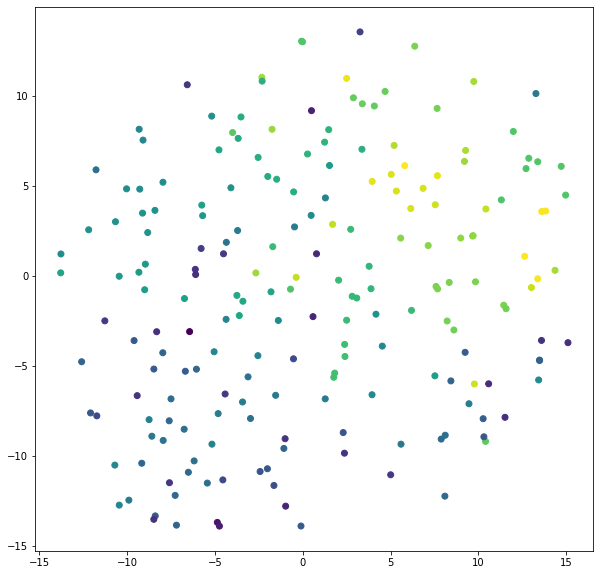

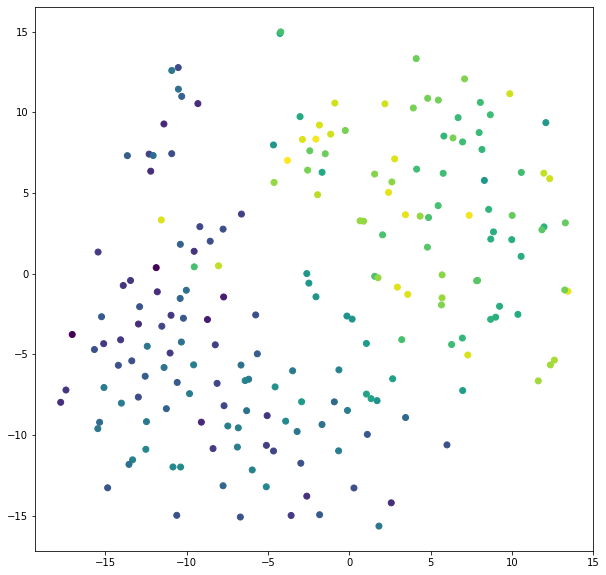

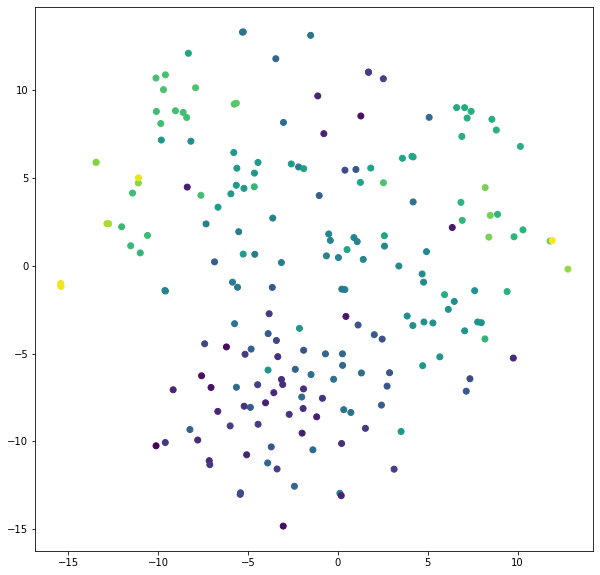

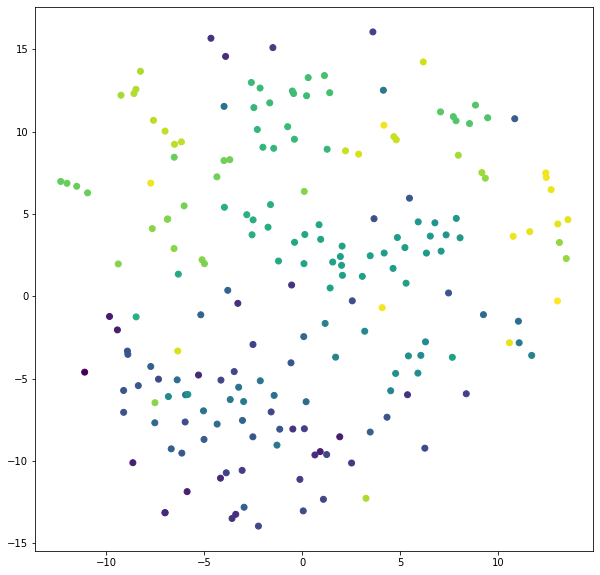

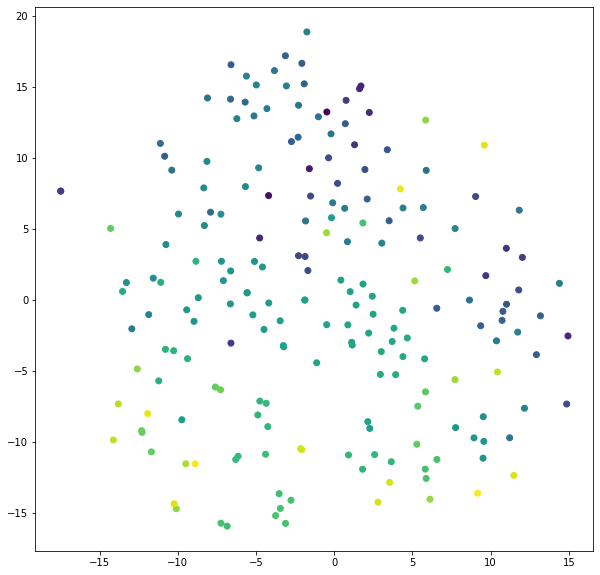

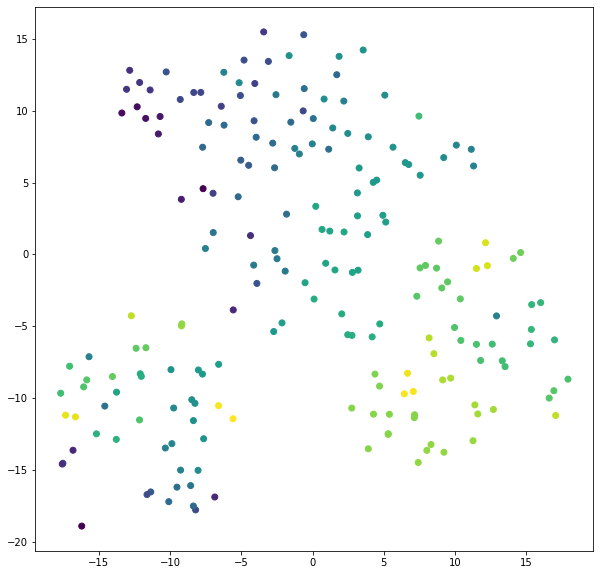

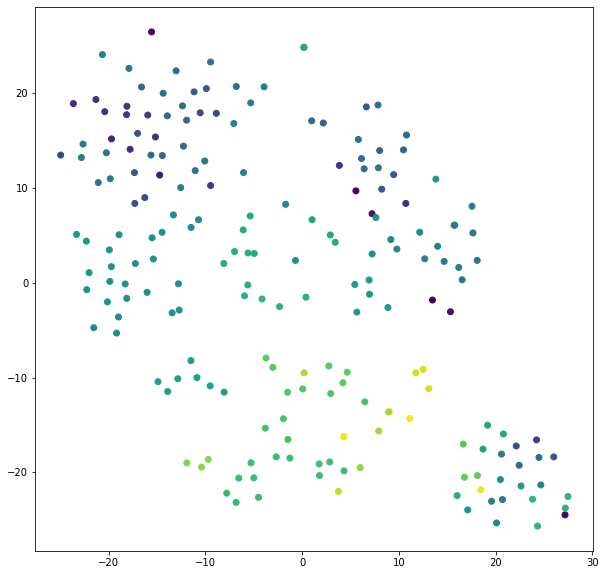

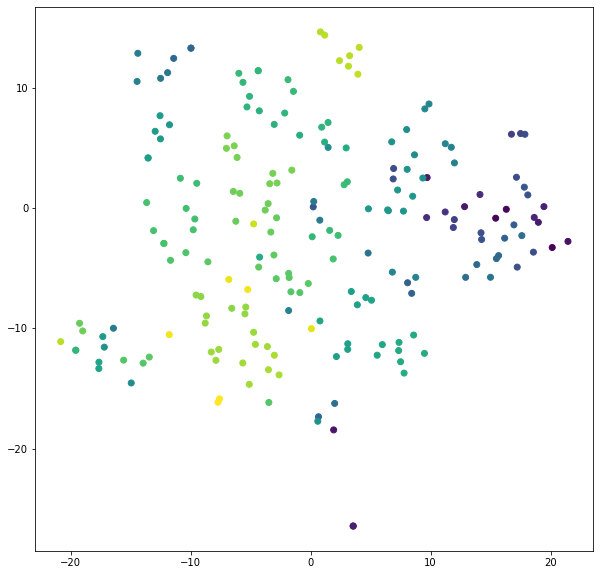

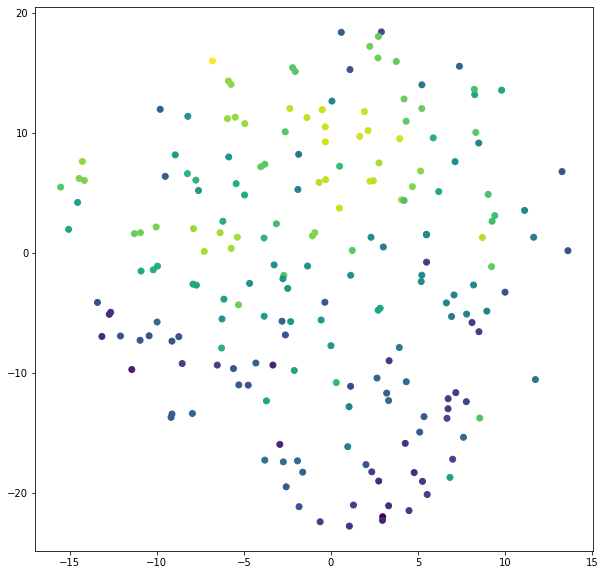

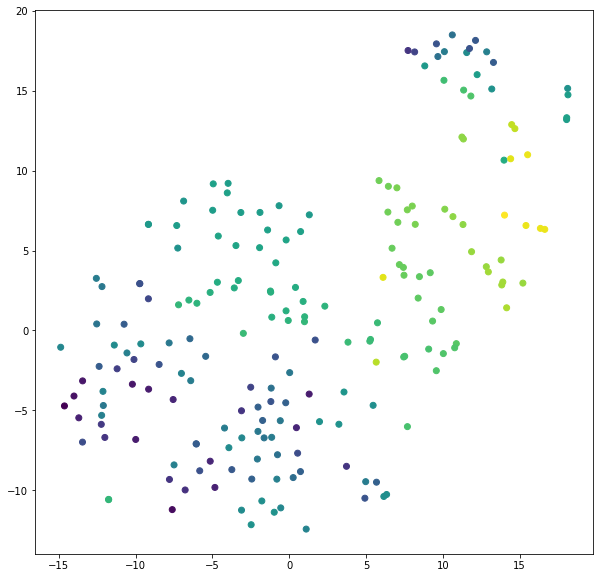

In [115]:
for i, idxs in instrument_indices.items():
    idxs = idxs[:200]
    x_instr = x[idxs]
    y_instr = [y[i] for i in idxs]
    
    mean = x_instr.mean(2) # x.mean([0, 2])
    std = x_instr.std(2) # x.std([0, 2])
    
    x_norm = (x_instr - mean.unsqueeze(-1)) / torch.where(std == 0.0, torch.ones_like(std), std).unsqueeze(-1)
    
    x_flat = torch.flatten(x_norm, start_dim=1)
    
    tsne = TSNE(n_components=2)
    x_2d = tsne.fit_transform(x_flat)
    
    colors = [a['pitch'] for a in y_instr]
    
    fig = plt.figure(figsize=(10, 10))
    plt.scatter(x_2d[:, 0], x_2d[:, 1], c=colors)
    plt.show()

In [322]:
x_2d_scaled = x_2d[:]

In [323]:
x_2d_scaled[:, 0] = (x_2d_scaled[:, 0] - x_2d_scaled[:, 0].min()) / (x_2d_scaled[:, 0].max() - x_2d_scaled[:, 0].min())
x_2d_scaled[:, 1] = (x_2d_scaled[:, 1] - x_2d_scaled[:, 1].min()) / (x_2d_scaled[:, 1].max() - x_2d_scaled[:, 1].min())

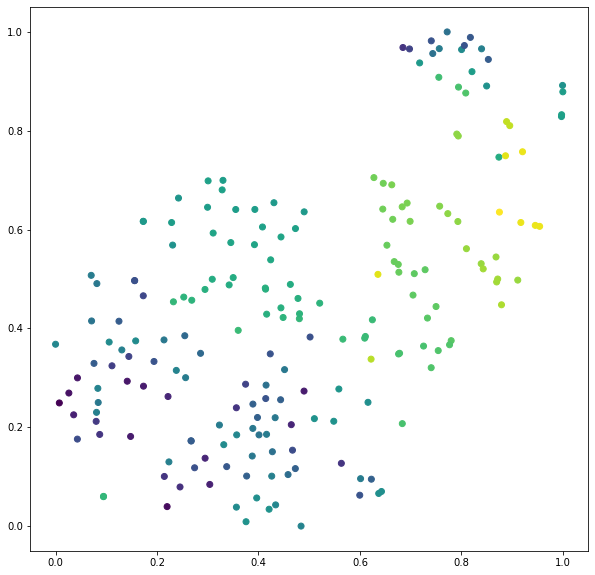

In [347]:
colors = [a['pitch'] for a in y_instr]

fig = plt.figure(figsize=(10, 10))
plt.scatter(x_2d_scaled[:, 0], x_2d_scaled[:, 1], c=colors)
plt.show()

In [348]:
def round_to_interval(x, interval):
    return round(x/interval)*interval

In [349]:
incr = 0.02

In [350]:
grid_points = [[round_to_interval(pt[0], incr), round_to_interval(pt[1], incr)] for pt in x_2d_scaled]

In [351]:
xv, yv = np.meshgrid(np.arange(0.0, 1.0+incr, incr), np.arange(0.0, 1.0+incr, incr))

In [352]:
avail_points = np.stack([xv.flatten(), yv.flatten()], axis=-1)
avail_points = [x for x in avail_points if x.tolist() not in grid_points]

In [353]:
new_grid_points = []
for pt in grid_points:
    if pt in new_grid_points:
        new_idx = np.argsort(list(map(lambda x : np.linalg.norm(pt - x), avail_points)))[0]
        pt = avail_points[new_idx].tolist()
        del avail_points[new_idx]

    new_grid_points.append(pt)

In [354]:
grid_points = np.array(grid_points)
new_grid_points = np.array(new_grid_points)

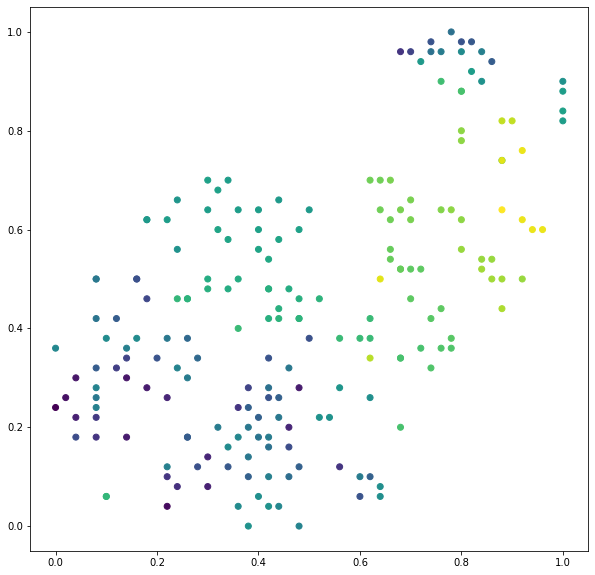

In [356]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(grid_points[:, 0], grid_points[:, 1], c=colors)
plt.show()

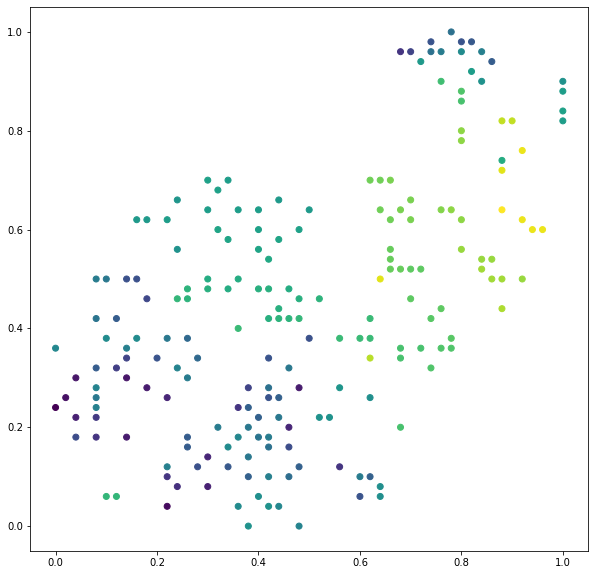

In [357]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(new_grid_points[:, 0], new_grid_points[:, 1], c=colors)
plt.show()

In [383]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

In [386]:
dbscan = DBSCAN()

clusters = dbscan.fit_predict(x_2d_scaled)

In [407]:
scores = []
n_clusters = list(range(2, 20))
for k in n_clusters:
    model = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
    model.fit(x_2d_scaled)
    
    scores.append(model.inertia_)

In [408]:
curve_scores = []
for i in range(1, len(scores)-1):
    curve_scores.append((i, scores[i+1] + scores[i-1] - 2 * scores[i]))

In [412]:
idx = sorted(curve_scores, key=lambda x : x[1], reverse=True)[0][0]

In [414]:
optimal_k = n_clusters[idx]

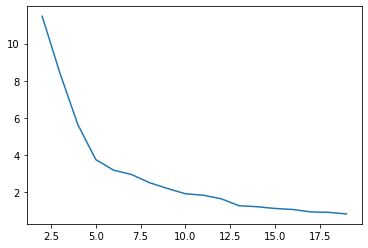

In [416]:
plt.plot(n_clusters, scores)

In [417]:
kmeans = KMeans(n_clusters=optimal_k)

In [418]:
clusters = kmeans.fit_predict(x_2d_scaled)

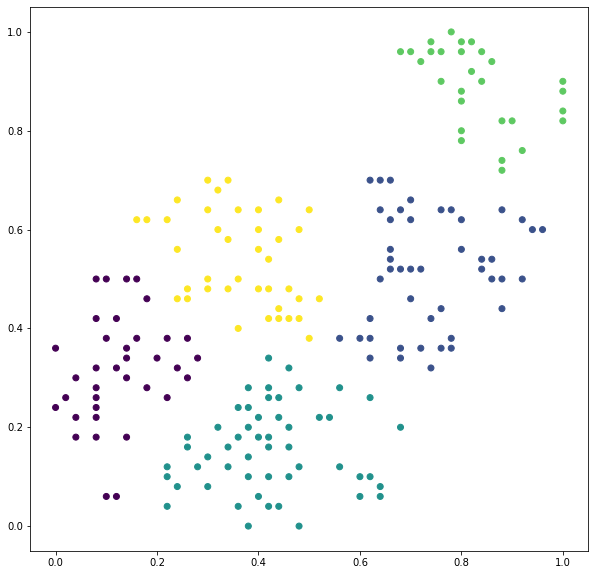

In [419]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(new_grid_points[:, 0], new_grid_points[:, 1], c=clusters)
plt.show()